In [1]:
# Standard library imports
import os
import random
import shutil
import glob

# Third-party libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K



In [2]:
# Training and validation generators
patch_dir = r'D:\Holland_Year_2\Block_B\Task5_Patches\dataset_transfer'

# Training image generator
train_image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(256, 256),
    batch_size=4,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training mask generator
train_mask_generator = ImageDataGenerator().flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(256, 256),
    batch_size= 4,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine training generators
train_generator = zip(train_image_generator, train_mask_generator)

# Validation image generator
val_image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(256, 256),
    batch_size=4,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Validation mask generator
val_mask_generator = ImageDataGenerator().flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(256, 256),
    batch_size=4,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine validation generators
val_generator = zip(val_image_generator, val_mask_generator)

Found 36663 images belonging to 1 classes.
Found 36663 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.


(256, 256, 1)


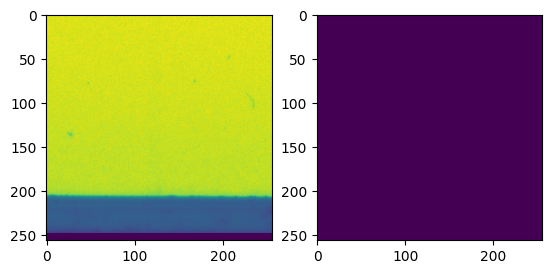

In [3]:
sample = val_generator.__next__()
fig, ax = plt.subplots(1, 2)
print(sample[0][0].shape)
ax[0].imshow(sample[0][0])
ax[1].imshow(sample[1][0])
plt.show()


(256, 256, 1)


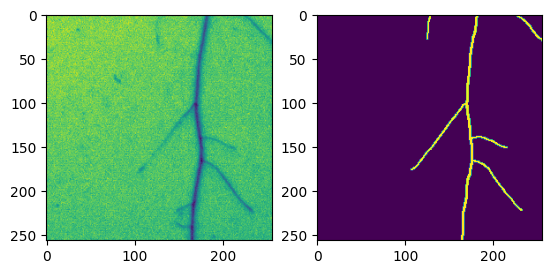

In [4]:
sample = train_generator.__next__()
fig, ax = plt.subplots(1, 2)
print(sample[0][0].shape)
ax[0].imshow(sample[0][0])
ax[1].imshow(sample[1][0])
plt.show()

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Function to calculate F1 score
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import Xception

# Function to create ASPP module
def AtrousSpatialPyramidPooling(inputs):
    shape = inputs.shape

    # 1x1 Convolution
    conv1 = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    # 3x3 Convolution with rate=6
    conv2 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=6, use_bias=False)(inputs)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    # 3x3 Convolution with rate=12
    conv3 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=12, use_bias=False)(inputs)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)

    # 3x3 Convolution with rate=18
    conv4 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=18, use_bias=False)(inputs)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)

    # Global Average Pooling
    gap = layers.GlobalAveragePooling2D()(inputs)
    gap = layers.Reshape((1, 1, shape[-1]))(gap)  # Fix shape inference issue
    gap = layers.Conv2D(256, (1, 1), use_bias=False)(gap)
    gap = layers.BatchNormalization()(gap)
    gap = layers.ReLU()(gap)
    gap = layers.UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(gap)

    # Concatenate all branches
    concat = layers.Concatenate()([conv1, conv2, conv3, conv4, gap])

    # Output Convolution
    output = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(concat)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)

    return output

# DeepLabV3+ model
def DeepLabV3Plus(input_shape):
    # Input Layer
    inputs = layers.Input(shape=input_shape)

    # Modify Xception backbone to accept grayscale input (single channel)
    # Pretrained weights are incompatible with 1-channel input, so set weights=None
    base_model = Xception(weights=None, include_top=False, input_tensor=layers.Conv2D(3, (1, 1), padding="same", name="input_to_rgb")(inputs))
    high_level_features = base_model.get_layer("block13_pool").output

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp = AtrousSpatialPyramidPooling(high_level_features)

    # Decoder
    low_level_features = base_model.get_layer("block4_pool").output
    low_level_features = layers.Conv2D(48, (1, 1), padding="same", use_bias=False)(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)
    low_level_features = layers.ReLU()(low_level_features)

    # Align shapes before concatenation
    aspp_upsampled = layers.UpSampling2D(size=(low_level_features.shape[1] // aspp.shape[1], low_level_features.shape[2] // aspp.shape[2]), interpolation="bilinear")(aspp)

    # Concatenate low-level and ASPP features
    concat = layers.Concatenate()([low_level_features, aspp_upsampled])

    # Decoder Convolutions
    decoder = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(concat)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.ReLU()(decoder)
    decoder = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.ReLU()(decoder)

    # Final Upsampling
    outputs = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(decoder)
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(outputs)  # Binary segmentation

    # Model
    model = Model(inputs, outputs)
    return model

# Parameters
input_shape = (256, 256, 1)  # Adjust input shape to match your dataset

# Create Model
model = DeepLabV3Plus(input_shape)

# Compile Model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_to_rgb (Conv2D)          (None, 256, 256, 3)  6           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_to_rgb[0][0]']           
                                )                                                                 
                                                                                              

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

In [9]:
cb = EarlyStopping(
    monitor='val_f1',
    patience=7,
    restore_best_weights=True,
    mode='max'
    )

In [10]:
checkpoint_cb = ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Path to save the model file
    monitor='val_f1',               # Metric to monitor
    verbose=1,                      # Verbosity level
    save_best_only=True,            # Save only the best model
    save_weights_only=False,        # Save the entire model (not just weights)
    mode='max',                     # 'max' since higher F1 is better
    save_freq='epoch'               # Save at the end of every epoch
)

In [11]:
with tf.device('/GPU:1'):    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_image_generator)//16,
        validation_data=val_generator,
        validation_steps=len(val_image_generator)//16,
        epochs=45,
        callbacks=[cb],
        verbose=1
)

Epoch 1/45


InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\35988\AppData\Local\Temp\ipykernel_8160\783501803.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/mul'
required broadcastable shapes
	 [[{{node binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_train_function_12169]

In [13]:
model.set_weights(model_checkpoint_cb.best_weights)


NameError: name 'model_checkpoint_cb' is not defined

In [19]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

NameError: name 'history' is not defined

In [21]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(loss) + 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

NameError: name 'history' is not defined

In [20]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
model_file_name = f'PetarPaskalev_232725_unet_model_3_256px_82F1.h5'
print(model_file_name)
model.save(model_file_name)

PetarPaskalev_232725_unet_model_3_256px_82F1.h5
